## Initializations and Dataset Overview

In [1]:
import sys
from pathlib import Path

# Get the project root (assuming notebook is in a subfolder of the project)
notebook_dir = Path().resolve()
project_root = notebook_dir.parent  # Adjust .parent depth based on your structure

# Add to path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## Imports

Let's start by getting all our imports. Keep in mind that PyTorch does not automatically detect and train on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon, replace cuda with mps.

In [2]:

import torch
import torch.nn as nn
from torch.optim import Adam  # Adam Optimizer
from torch.utils.data import Dataset, DataLoader  # Dataset class and DataLoader for creating the objects
from torchinfo import summary  # Visualize the model layers and number of parameters

from sklearn.model_selection import train_test_split  # Split the dataset (train, validation, test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Regression metrics
import matplotlib.pyplot as plt  # Plotting the training progress at the end
import pandas as pd  # Data reading and preprocessing
import numpy as np  # Mathematical operations
import seaborn as sns

from sklearn.datasets import fetch_california_housing

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print(device)

cpu


## EDA & Preprocessing

In [3]:
# Load California housing dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Check the first few rows of the dataset
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
# Description of the dataset
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
# Display dataset information
from utils import check_data_information
desc_df = check_data_information(df, df.columns)

print("Dataset information:")
print(f"Original data shape: {df.shape}")
display(desc_df)

Dataset information:
Original data shape: (20640, 9)


,Feature,Data Type,Null Values,Null Percentage,Duplicated Values,Unique Values,Unique Sample
0,MedInc,float64,0,0.0,0,12928,"8.3252, 8.3014, 7.2574, 5.6431, 3.8462"
1,HouseAge,float64,0,0.0,0,52,"41.0, 21.0, 52.0, 42.0, 50.0"
2,AveRooms,float64,0,0.0,0,19392,"6.984126984126984, 6.238137082601054, 8.288135..."
3,AveBedrms,float64,0,0.0,0,14233,"1.0238095238095237, 0.9718804920913884, 1.0734..."
4,Population,float64,0,0.0,0,3888,"322.0, 2401.0, 496.0, 558.0, 565.0"
5,AveOccup,float64,0,0.0,0,18841,"2.5555555555555554, 2.109841827768014, 2.80225..."
6,Latitude,float64,0,0.0,0,862,"37.88, 37.86, 37.85, 37.84, 37.83"
7,Longitude,float64,0,0.0,0,844,"-122.23, -122.22, -122.24, -122.25, -122.26"
8,MedHouseVal,float64,0,0.0,0,3842,"4.526, 3.585, 3.521, 3.413, 3.422"


In [6]:
# Drop Latitude and Longitude
df = df.drop(columns=['Latitude', 'Longitude'])

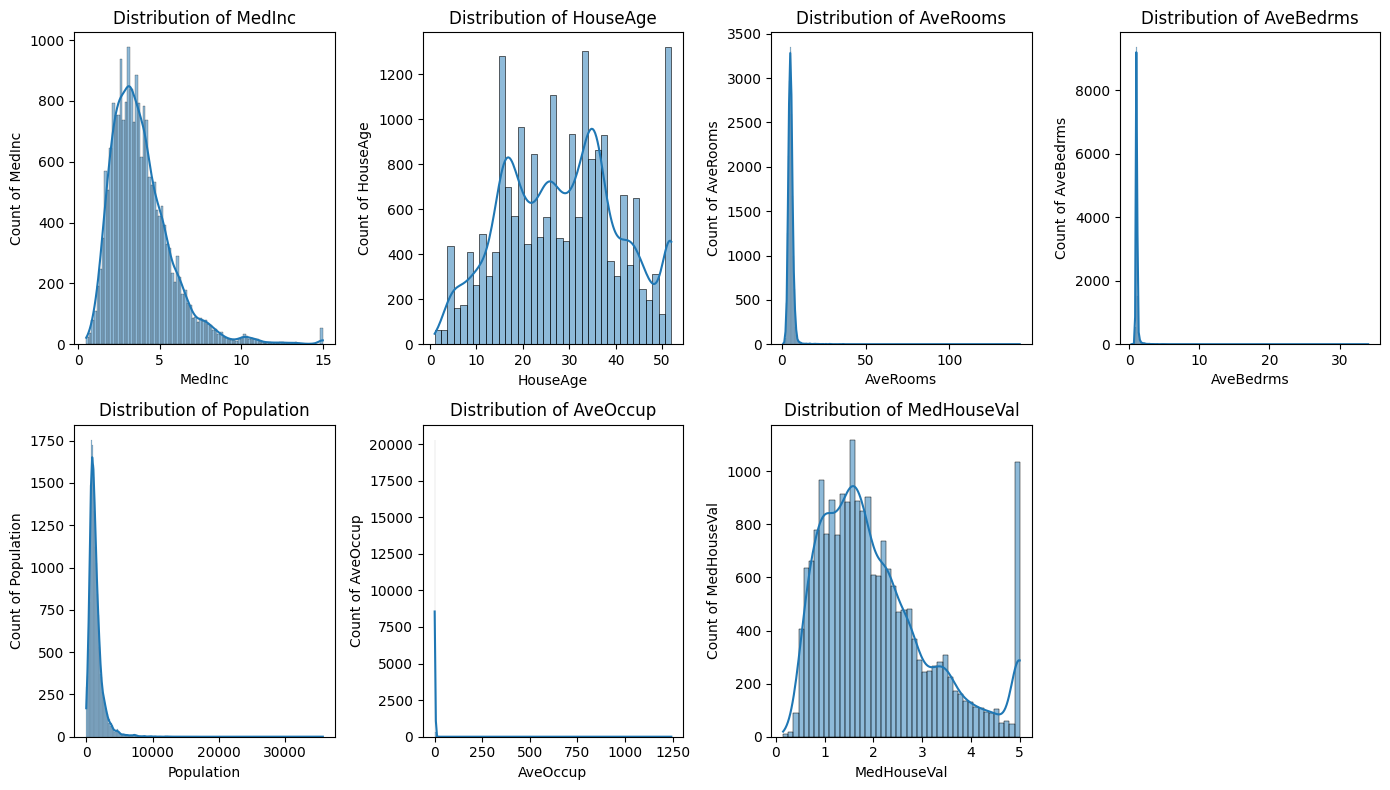

,Feature,overall_count,overall_mean,overall_std,overall_min,overall_25%,overall_50%,overall_75%,overall_max,overall_range,overall_IQR,overall_CV,overall_skewness,overall_kurtosis
0,MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100,14.500200,2.179850,49.082490,1.646537,4.951034
1,HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000,51.000000,19.000000,43.944774,0.060326,-0.800726
2,AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091,141.062937,1.611665,45.573278,20.696365,879.139966
3,AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667,33.733333,0.093447,43.213422,31.314680,1636.315218
4,Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000,35679.000000,938.000000,79.444447,4.935500,73.535009
5,AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333,1242.641026,0.852520,338.235621,97.632465,10648.430334
6,MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010,4.850020,1.451250,55.785531,0.977692,0.327500


In [7]:
# Checking the distribution and statistical summary of the numerical values
from utils import describe_numerical_combined, plot_dynamic_hisplots_kdeplots

# Hisplot function implementation
plot_dynamic_hisplots_kdeplots(df=df, col_series=df.columns, ncols=4, figsize=(14, 8))

# Display the overall statistics for numerical columns
numerical_summary = describe_numerical_combined(df, df.columns)
display(numerical_summary)

Amount of Rows: 20640
Amount of Outlier Rows (Across All Columns): 4328
Amount of Non-Outlier Rows (Across All Columns): 16312
Percentage of Outliers: 20.97%



,Column Name,Outlier Exist,Lower Limit,Upper Limit,Outlier Data,Non-Outlier Data,Outlier Percentage (%)
0,MedInc,True,-0.706375,8.013025,681,19959,3.30
1,HouseAge,False,-10.500000,65.500000,0,20640,0.00
2,AveRooms,True,2.023219,8.469878,511,20129,2.48
3,AveBedrms,True,0.865909,1.239697,1424,19216,6.90
4,Population,True,-620.000000,3132.000000,1196,19444,5.79
5,AveOccup,True,1.150961,4.561041,711,19929,3.44
6,MedHouseVal,True,-0.980875,4.824125,1071,19569,5.19


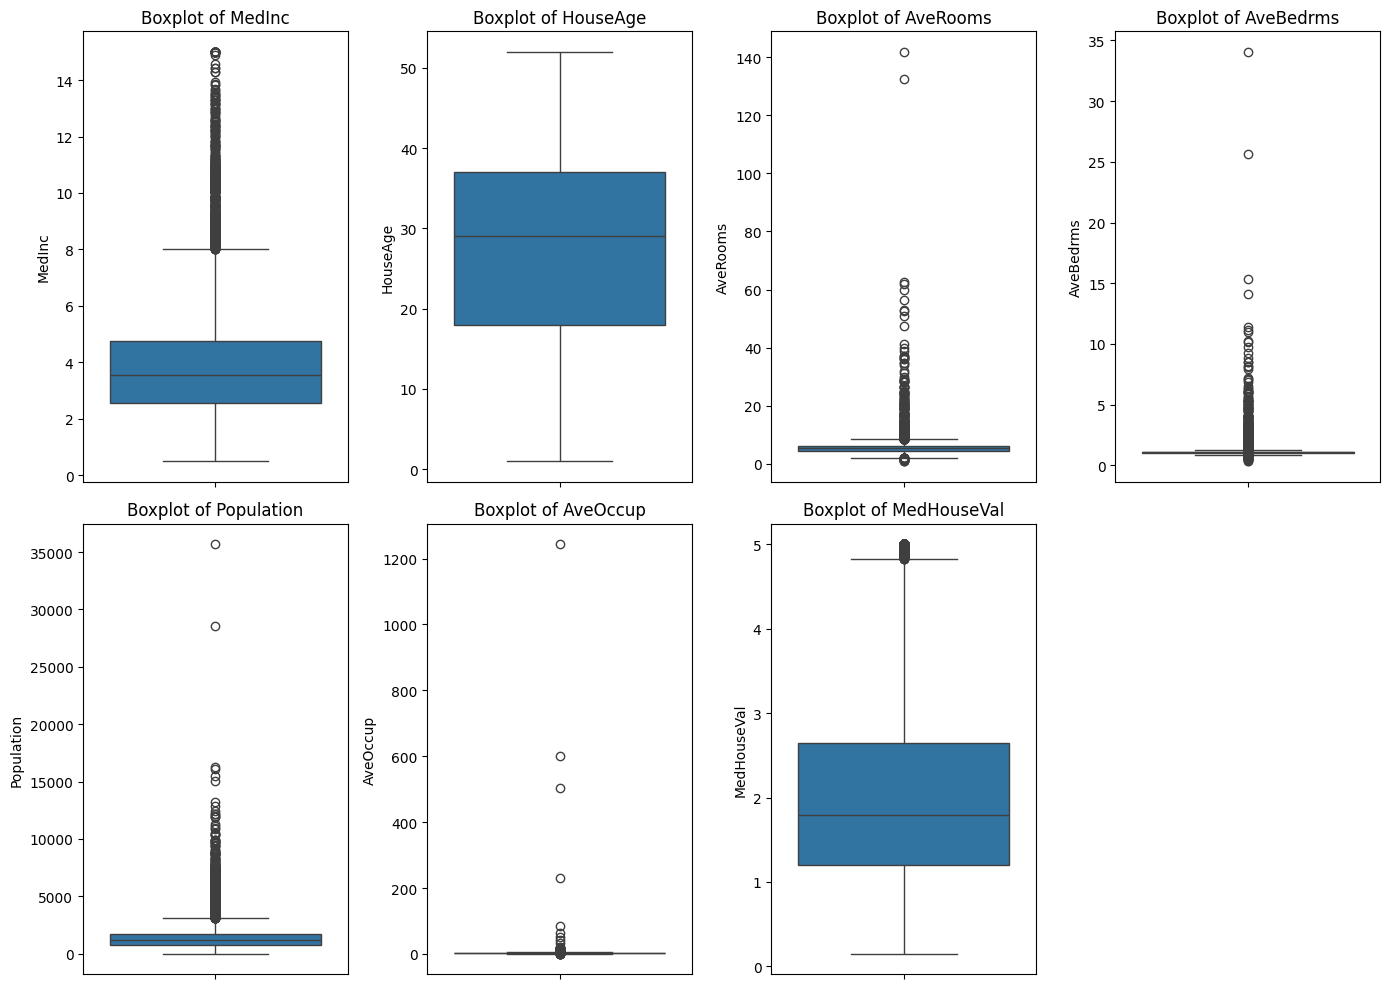

In [8]:
# Checking the outlier of the dataset
from utils import plot_dynamic_boxplots_violinplots, filter_outliers

# Check the outliers with IQR
check_outliers_cols = list(df.columns) + ['MedHouseVal'] if 'MedHouseVal' not in df.columns else df.columns
summary = filter_outliers(df, columns=check_outliers_cols, detect_only=True)
display(summary)

# Visualize the outliers
plot_dynamic_boxplots_violinplots(df, check_outliers_cols, plot_type="boxplot", ncols=4, orientation="v", figsize=(14, 10))

In [9]:
# Implement the outliers handling
df_outlier_handle = filter_outliers(df, columns=check_outliers_cols, method='iqr', threshold=1.25, detect_only=False)

# Check the outliers after handling
summary = filter_outliers(df_outlier_handle, columns=check_outliers_cols, detect_only=True)
display(summary)

Amount of Rows: 15095
Amount of Outlier Rows (Across All Columns): 230
Amount of Non-Outlier Rows (Across All Columns): 14865
Percentage of Outliers: 1.52%



,Column Name,Outlier Exist,Lower Limit,Upper Limit,Outlier Data,Non-Outlier Data,Outlier Percentage (%)
0,MedInc,False,-0.375550,7.482050,0,15095,0.00
1,HouseAge,False,-9.500000,66.500000,0,15095,0.00
2,AveRooms,True,2.375087,7.903025,26,15069,0.17
3,AveBedrms,True,0.875146,1.215376,8,15087,0.05
4,Population,True,-367.000000,2785.000000,139,14956,0.92
5,AveOccup,False,1.258166,4.392985,0,15095,0.00
6,MedHouseVal,True,-0.741250,4.368750,58,15037,0.38


<Figure size 1500x1500 with 0 Axes>

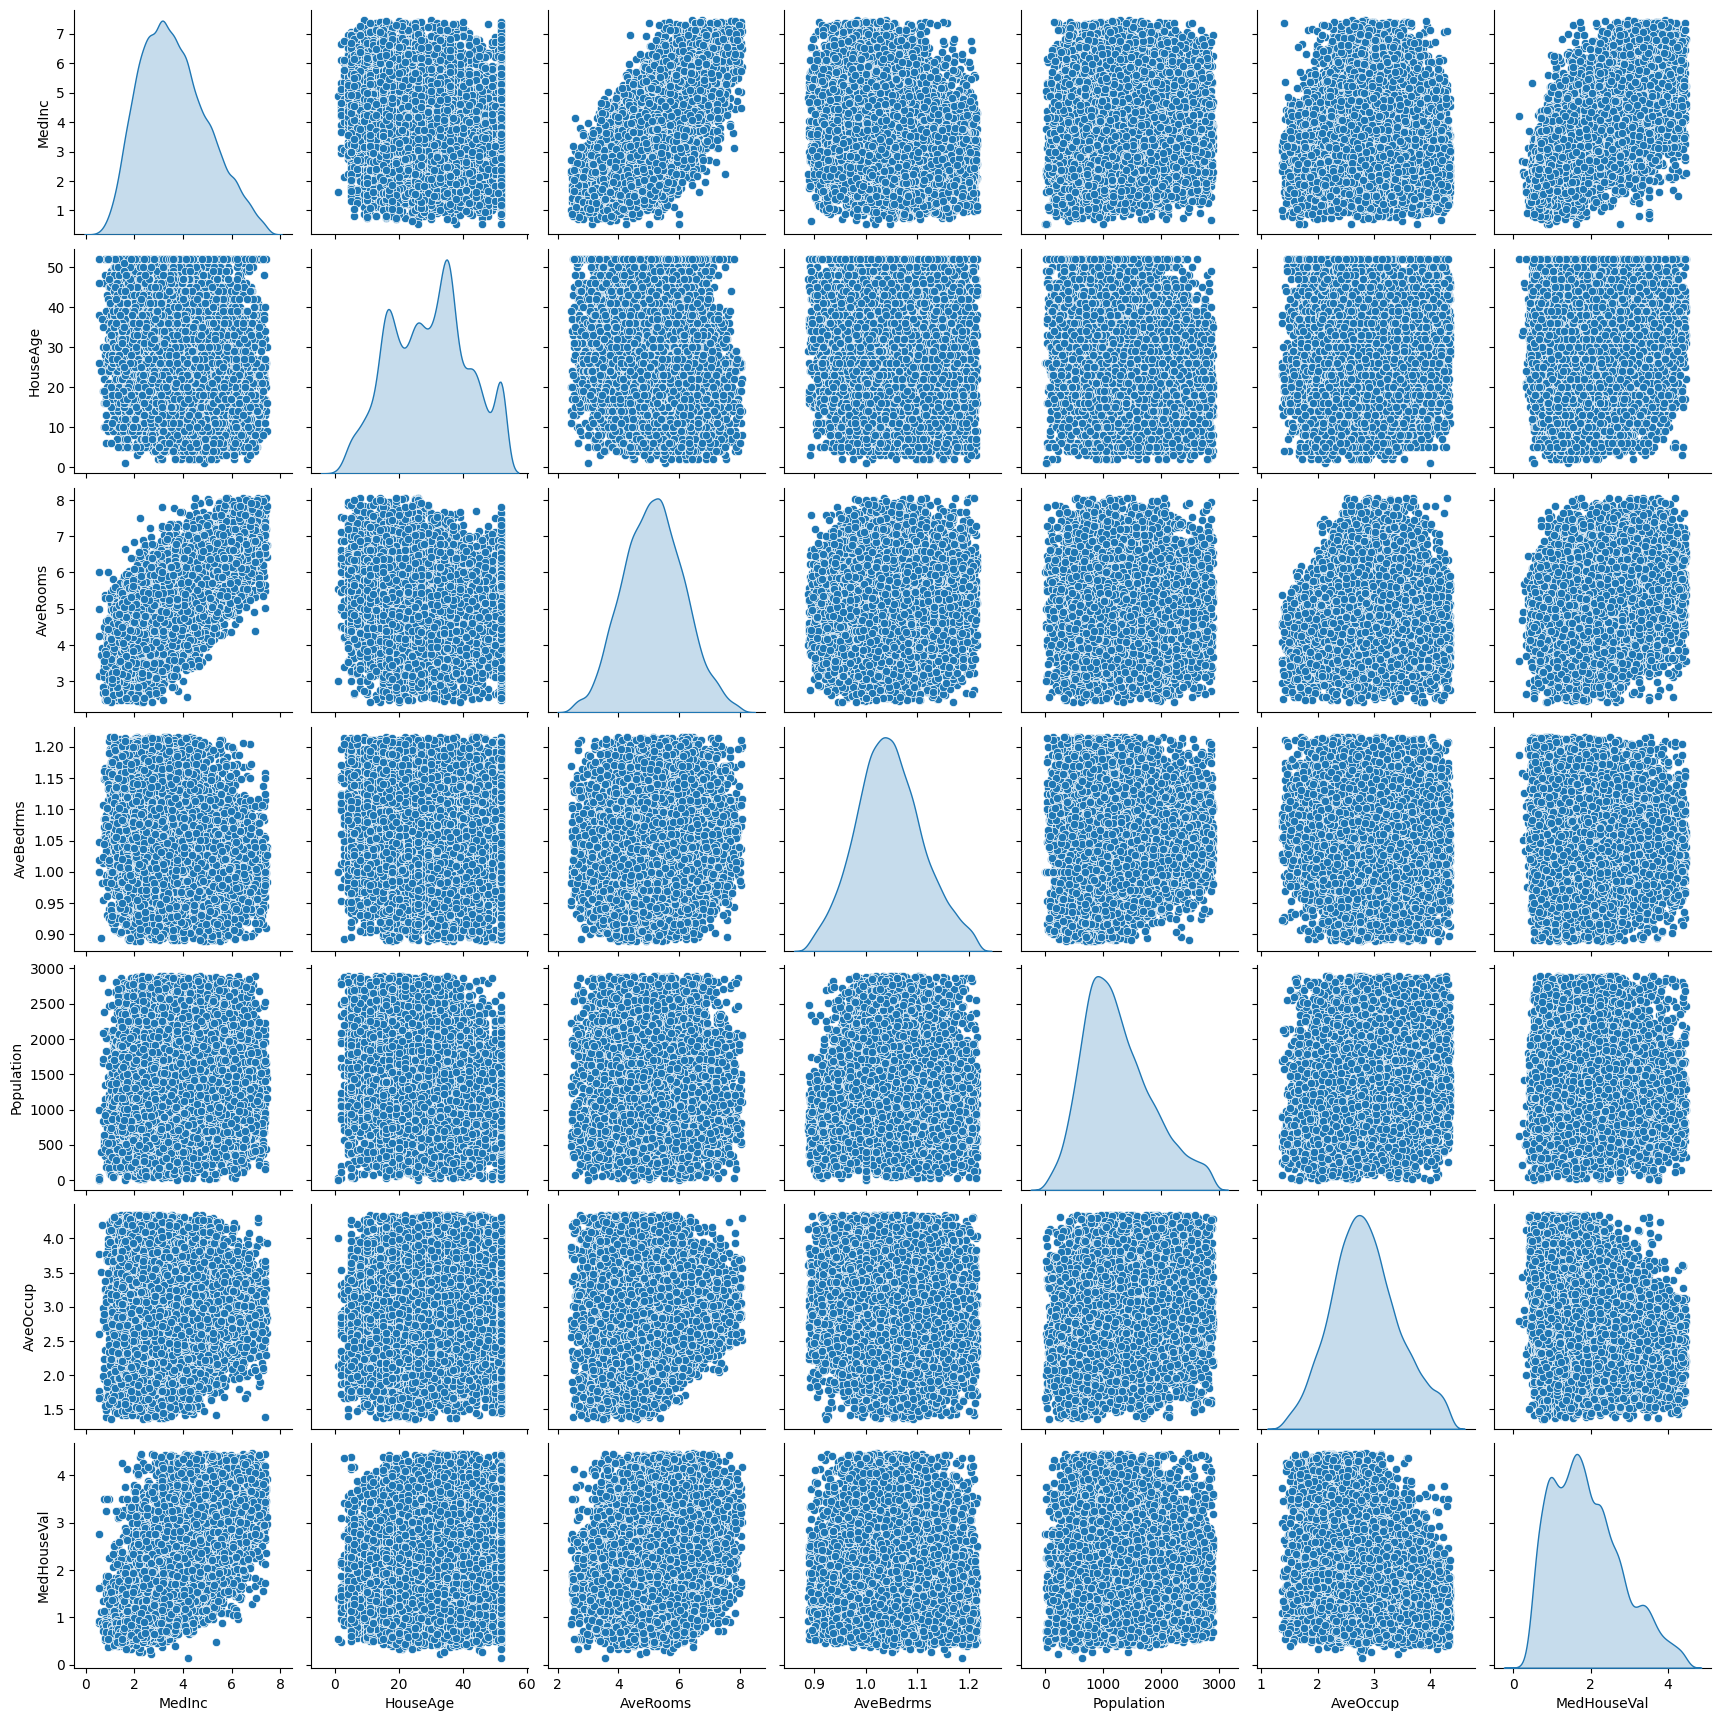

In [10]:
# Check the pairplot
pairplot_cols = list(df.columns) + ['MedHouseVal'] if 'MedHouseVal' not in df.columns else df.columns
plt.figure(figsize=(15, 15))
sns.pairplot(data=df_outlier_handle[pairplot_cols], diag_kind='kde')
plt.show()

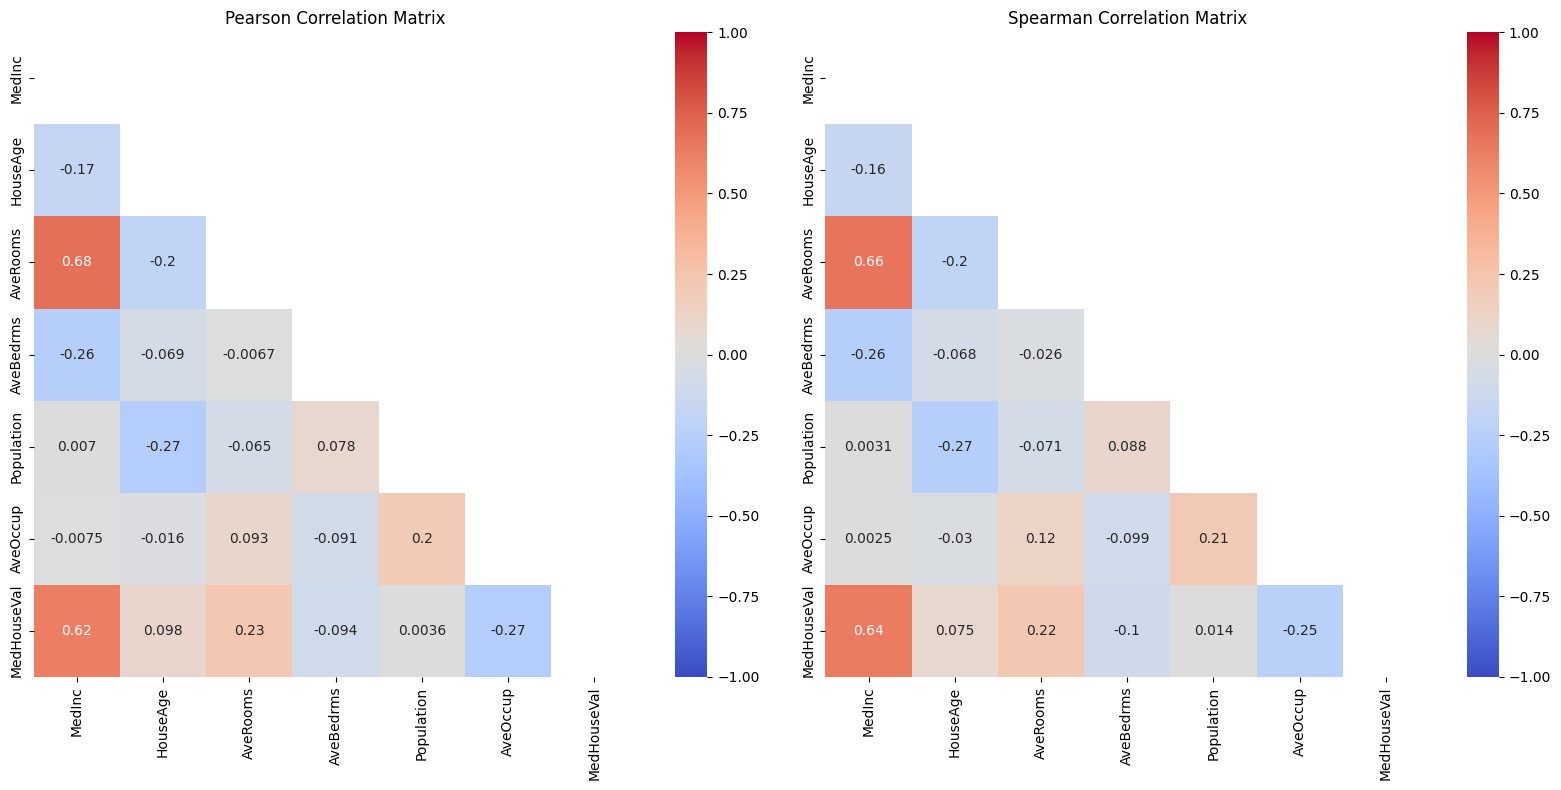

In [11]:
# Check correlation matrix
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
mask = np.triu(np.ones_like(df_outlier_handle.corr(), dtype=bool))
corr_matrix_pearson = df_outlier_handle.corr(method='pearson')
corr_matrix_spearman = df_outlier_handle.corr(method='spearman')

# Visualize the correlation matrix - Pearson
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, mask=mask, ax=ax[0])
ax[0].set_title('Pearson Correlation Matrix')

# Visualize the correlation matrix - Spearman
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, mask=mask, ax=ax[1])
ax[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()

## Data Splitting and Feature Scaling

We will detect the inputs and the outputs of the data which are X and y respectively.

Then we will split our data into the following:

- Training Size 70%
- Validation Size 15%
- Testing Size 15%

We will do this by splitting our data twice using the train_test_split function in sklearn. The function takes inputs, outputs and the testing size. After that we will print the training, validation and testing shapes and sizes.

In [12]:
# Separate features and target
X = df_outlier_handle.drop(columns=["MedHouseVal"])
y = df_outlier_handle["MedHouseVal"]

# # Convert to numpy arrays
# X = np.array(X)  # Replace with your feature matrix
# y = np.array(y)  # Replace with your target variable

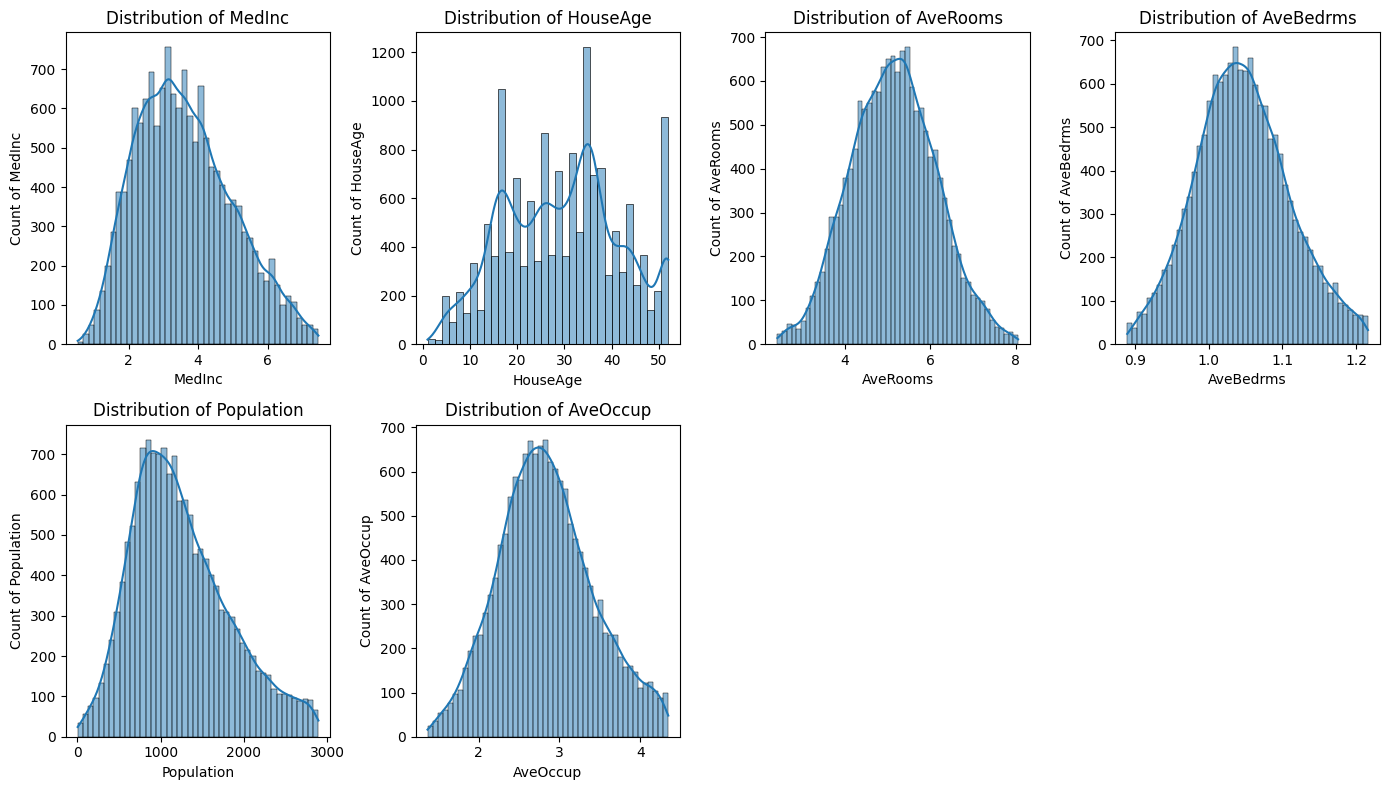

In [13]:
# Hisplot function implementation
plot_dynamic_hisplots_kdeplots(df=X, col_series=X.columns, ncols=4, figsize=(14, 8))

In [14]:
# Split the dataset into train and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the test dataset into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply scaling to the datasets
from utils import feature_scaling

all_features = X.columns.tolist()

# Fit on train data
X_train_scaled, scalers = feature_scaling(
    X_train,
    scaling_config={
        'standard': {
            'columns': all_features
        }
    }
)

# Transform only validation and test data
X_test_scaled, _ = feature_scaling(
    X_test,
    scaling_config={
        'standard': {
            'columns': all_features
        }
    },
    scaler=scalers
)

X_val_scaled, _ = feature_scaling(
    X_val,
    scaling_config={
        'standard': {
            'columns': all_features
        }
    },
    scaler=scalers
)

# Turn everything into a numpy array
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
X_val_scaled = np.array(X_val_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Display the shapes of the datasets
print(f"Training set is: {X_train.shape[0]} rows which is {round(X_train.shape[0]/(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]),4)*100}%")
print(f"Validation set is: {X_val.shape[0]} rows which is {round(X_val.shape[0]/(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]),4)*100}%")
print(f"Testing set is: {X_test.shape[0]} rows which is {round(X_test.shape[0]/(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]),4)*100}%")

print(f"\nFeature dimensions: {X_train.shape[1]}")

Training set is: 10566 rows which is 70.0%
Validation set is: 2265 rows which is 15.0%
Testing set is: 2264 rows which is 15.0%

Feature dimensions: 6


## Dataset Object

Now we will create the dataset object. This part is not complex but it's a bit tricky. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training. You can use the dataset as is, but let's keep things professional and efficient. 

First we define our class that will be taking the main Dataset class with the concept of inheritance. There is a big class in PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the cell below, we rebuilt the constructor function which is `__init__`. We put X and y as parameters to this function which are the inputs and outputs respectively, then inside the function we define the inputs and convert them to tensors, then convert the outputs to tensors and we make the numbers as `float32`. Additionally, we moved all our data to the cuda device. Then we modified the `__len__` and the `__getitem__` to match our needs which gets the specific length/shape of the data, and the data of specific row in our data respectively.

**Important difference from classification**: For regression, we don't need to convert y to long integers - we keep it as float32 since we're predicting continuous values, not classes.

In [15]:
# Create the dataset object for regression
class RegressionDataset(Dataset):

    # Constructor function
    def __init__(self, X, y):
        # Convert to tensors (pytorch only takes tensors) and move to device
        # Use torch.from_numpy() for better conversion from numpy arrays
        # or ensure the arrays are numeric first
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X.astype(np.float32)).to(device)
        else:
            self.X = torch.tensor(X, dtype=torch.float32).to(device)
        
        # For regression, y should be float32, not long (unlike classification)
        if isinstance(y, np.ndarray):
            self.y = torch.from_numpy(y.astype(np.float32)).to(device)
        else:
            self.y = torch.tensor(y, dtype=torch.float32).to(device)
    
    # Get the length of the data
    def __len__(self):
        return len(self.X)

    # Get the data of specific index
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
# Create object for training, validation and testing
training_data = RegressionDataset(X_train_scaled, y_train)
validation_data = RegressionDataset(X_val_scaled, y_val)
testing_data = RegressionDataset(X_test_scaled, y_test)

## Training Hyperparameters

Now we are setting the training hyperparameters. We define some variables which are the batch size, number of training epochs, hidden neurons, and learning rate.

For regression tasks, you might want to experiment with:
- Different numbers of hidden layers
- Different activation functions (ReLU is common for hidden layers)
- Learning rate scheduling
- Different optimizers

In [16]:
BATCH_SIZE = 64
EPOCHS = 50
HIDDEN_NEURONS_1 = 64  # First hidden layer
HIDDEN_NEURONS_2 = 32  # Second hidden layer
LR = 1e-3
WEIGHT_DECAY = 1e-5
DROPOUT_RATE = 0.3

## Data Loaders

This concept may seem complicated, but it's very easy. PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

DataLoader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs. If you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most cases you need to train through using batches. DataLoader allows you to loop through the batches easily during the training. When you create a dataloader, you define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In the next cell, we define a dataloader for each of our data (training, validation and testing).

In [17]:
# A dataloader is a class that loads the data in batches. 
# It's basically an object that we use to do the for loop during each epoch.

# Create DataLoader objects
training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Example of what the dataloader object looks like

# The dataloader returns batches of data in each iteration
# 'batch' contains the input features (X) for multiple samples
# 'label' contains the corresponding target values (y) for those samples
# Notice that each run of the for loop will return a different batch of data

for batch, label in training_dataloader:
    print("Batch shape (features):", batch.shape)  # [batch_size, num_features]
    print("First sample features:", batch[0])  
    
    print("="*100)

    print("Label shape (targets):", label.shape)  # [batch_size]
    print("First few target values (prices):", label[:5])  # Show first 5 prices
    break  # Only show one batch as an example

Batch shape (features): torch.Size([64, 6])
First sample features: tensor([ 1.0535,  0.2846,  1.0595, -0.6102, -0.0925, -0.1017])
Label shape (targets): torch.Size([64])
First few target values (prices): tensor([2.6420, 1.5820, 3.3570, 1.9380, 1.1860])


## Model Class

Creating a model in PyTorch seems not very straightforward in the beginning, but if you understand how machine learning and deep learning works, it will be easy for you to understand PyTorch structure easily.

In the next cell we define a new class `RegressionModel` that inherits from `nn.Module` like we did for the dataset. Remember, in simple terms, we want to redefine some functions in the class to match our needs. In the constructor which is `__init__`, then `super(RegressionModel, self).__init__()` calls the constructor of the parent class nn.Module to ensure it's properly initialized.

Then, we create our layers:
- **Input layer**: Takes the input features and transforms them to the first hidden layer
- **Hidden layers**: With ReLU activation for non-linearity
- **Output layer**: Produces a single continuous value (the predicted price)

**Key differences from classification:**
1. **No Sigmoid/Softmax at the end**: For regression, we output a raw continuous value, not a probability
2. **Output size is 1**: We're predicting a single continuous value (price)
3. **ReLU activation**: Commonly used in hidden layers for regression tasks

In the function `forward`, this function is the forward propagation of the model - how the data flows inside the model from the input to the output. This means we can control this completely. That's how PyTorch is so customizable!

In [19]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        # Call the parent class (nn.Module) constructor
        # This initializes all the PyTorch machinery needed for your model
        super(RegressionModel, self).__init__()

        # First hidden layer: takes input features and transforms them
        # input_size = number of input features (columns in your dataset)
        # HIDDEN_NEURONS_1 = number of neurons in the first hidden layer
        self.hidden1 = nn.Linear(input_size, HIDDEN_NEURONS_1)
        
        # Second hidden layer: takes output from first hidden layer
        self.hidden2 = nn.Linear(HIDDEN_NEURONS_1, HIDDEN_NEURONS_2)
        
        # Output layer: produces a single continuous value (the predicted price)
        # Unlike classification, we output 1 value, not a probability distribution
        self.output = nn.Linear(HIDDEN_NEURONS_2, 1)

        # Dropout for regularization
        # Dropout randomly sets a fraction of input units to 0 during training
        # This prevents overfitting by forcing the network to learn redundant representations
        # DROPOUT_RATE determines the probability of dropping a neuron (e.g., 0.2 = 20% dropout)
        # During inference/testing, dropout is automatically disabled
        self.dropout = nn.Dropout(DROPOUT_RATE)
        
        # ReLU activation function for hidden layers
        # ReLU(x) = max(0, x) - introduces non-linearity and prevents vanishing gradients
        # This is the most common activation for regression tasks
        self.relu = nn.ReLU()
        
        # Other activation options you could try for hidden layers:
        # self.leaky_relu = nn.LeakyReLU()  # Allows small negative values
        # self.elu = nn.ELU()  # Exponential Linear Unit, smoother than ReLU
        # self.tanh = nn.Tanh()  # Output range [-1, 1]
        # Note: For regression OUTPUT layer, we typically use NO activation (linear output)

    def forward(self, x):
        # Define how data flows through the network (forward pass)
        # x starts as your input data (batch of samples with features)
        
        # Pass through first hidden layer and apply ReLU activation
        x = self.relu(self.hidden1(x))
        
        # Apply dropout after first hidden layer
        # This randomly drops neurons during training to prevent overfitting
        # Dropout is only active during training, not during evaluation/testing
        x = self.dropout(x)
        
        # Pass through second hidden layer and apply ReLU activation
        x = self.relu(self.hidden2(x))
        
        # Apply dropout after second hidden layer
        x = self.dropout(x)
        
        # Pass through output layer (NO activation here for regression)
        # This gives us a raw continuous value as the prediction
        x = self.output(x)
        
        # Return the predicted value (house price)
        return x

## Model Creation

Now let's create our model and move it to the assigned device (cuda if you have GPU or the CPU if you don't have any GPUs). Additionally, we will print a `summary` of the model using the summary function which will take our model and the input size.

In [20]:
# Instantiate the neural network model
# RegressionModel() creates a new instance of our custom neural network class
# We pass the input size (number of features) to the constructor
# .to(device) moves the model to the appropriate device (GPU if available, otherwise CPU)
# This ensures all model parameters and computations happen on the correct hardware
model = RegressionModel(input_size=X_train.shape[1]).to(device)

# Display a summary of the model architecture
# torchinfo.summary() prints layer-by-layer details including:
# - Layer types and names
# - Output shapes at each layer
# - Number of trainable parameters (weights and biases)
# input_size specifies the input shape: a tuple with (batch_size, num_features)
# This helps verify the model structure and parameter count before training
from torchinfo import summary as model_summary
model_summary(model, input_size=(1, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
RegressionModel                          [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   448
├─ReLU: 1-2                              [1, 64]                   --
├─Dropout: 1-3                           [1, 64]                   --
├─Linear: 1-4                            [1, 32]                   2,080
├─ReLU: 1-5                              [1, 32]                   --
├─Dropout: 1-6                           [1, 32]                   --
├─Linear: 1-7                            [1, 1]                    33
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

## Loss and Optimizer

In the next cell, we will create the loss function and the optimizer.

**Key difference from classification:**
- For **classification**, we used Binary Cross Entropy (BCE) loss
- For **regression**, we use Mean Squared Error (MSE) loss, which measures the average squared difference between predictions and actual values

The optimizer `Adam` will take the model parameters/weights and the learning rate, same as classification.

In [21]:
# Define the loss function for regression
# MSELoss (Mean Squared Error Loss) calculates the average of squared differences
# between predictions and actual values: loss = mean((prediction - actual)^2)
# This penalizes larger errors more heavily than smaller ones
# 
# Other regression loss options:
# - nn.L1Loss() - Mean Absolute Error, less sensitive to outliers
# - nn.SmoothL1Loss() - Huber loss, combines MSE and MAE benefits
# - nn.HuberLoss() - Similar to SmoothL1Loss with configurable delta
criterion = nn.MSELoss()

# Define the optimizer to update model weights during training
# Adam (Adaptive Moment Estimation) adjusts learning rates automatically for each parameter
# model.parameters() gives all trainable weights/biases to optimize
# lr (learning rate) controls how big the weight updates are each step
# weight_decay adds L2 regularization penalty to prevent overfitting by penalizing large weights
# It adds weight_decay * weight^2 to the loss, encouraging smaller weight values
# This helps the model generalize better to unseen data
# Other optimizer options:
# - torch.optim.SGD() - basic stochastic gradient descent, simpler but may need tuning
# - torch.optim.AdamW() - Adam with weight decay, better generalization
# - torch.optim.RMSprop() - good for RNNs
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

## Training

Now comes the exciting part. As we mentioned several times, nothing is complex here if you know how deep learning works. You just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs. But before that we define 4 lists and inside the loop we define another 4 variables.

### Variables:
* `total_loss_train`: here we will keep track of the training loss progress during each epoch, we calculate the loss during the batch and we use the loss value to optimize and modify the model parameters.

* `total_loss_val`: here we will keep track of the validation loss progress during each epoch, we calculate the loss during the batch to monitor for overfitting.

### Lists:
* `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

* `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.

**Key differences from classification:**
1. We don't track accuracy (that's for classification). For regression, loss (MSE) is our main metric.
2. We can also track additional metrics like MAE (Mean Absolute Error) or R² score for better understanding.
3. No rounding or class comparison - we directly compare continuous predicted values with actual values.

### Training Process
Then, we start to loop through the training dataloaders. In the loop, we get our data from the data loader, and the inputs and labels are already on the device. We allow the model to make a prediction (forward propagation), then we get the output of the model and compare it with our original output using the loss criterion. We use the squeeze function to remove unnecessary dimensions. We add the loss amount to `total_loss_train`. 

Then we do `batch_loss.backward()` which performs backpropagation, we use the optimizer to update the weights using `optimizer.step()`, and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step.

### Validation
After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. Inside that we start with `torch.no_grad()` which means that we need the model to do predictions without being trained. We just need to see the validation performance. Then we do the same steps which are predicting and calculating loss.

At the end we print after each epoch the epoch number, training loss, and validation loss. We use the printing of "=" signs just for making the printing output look clean.

In [22]:
# Initialize empty lists to store metrics for each epoch (used for plotting later)
total_loss_train_plot = []  # Stores training loss per epoch
total_loss_validation_plot = []  # Stores validation loss per epoch

# Main training loop - runs for the specified number of epochs
for epoch in range(EPOCHS):
    # Reset metrics at the start of each epoch
    total_loss_train = 0  # Accumulates loss during training
    total_loss_val = 0  # Accumulates loss during validation
    
    # Set model to training mode (enables dropout, batch norm updates, etc.)
    model.train()

    ## Training
    # Loop through all batches in the training dataset
    for data in training_dataloader:

        # Unpack the batch into inputs (features) and labels (target prices)
        inputs, labels = data

        # IMPORTANT: Clear gradients BEFORE forward pass (not after backward)
        # This prevents gradient accumulation from previous batches
        optimizer.zero_grad()

        # Forward pass: feed inputs through the model to get predictions
        # squeeze(1) removes dimension 1 to match label shape (e.g., [64,1] -> [64])
        prediction = model(inputs).squeeze(1)

        # Calculate loss: Mean Squared Error between predictions and actual prices
        batch_loss = criterion(prediction, labels)

        # Backward pass: calculate gradients (how to adjust weights)
        batch_loss.backward()
        
        # Update model weights based on calculated gradients
        optimizer.step()

        # Add this batch's loss to the running total
        # .item() converts the tensor to a Python number
        total_loss_train += batch_loss.item()

    ## Validation
    # Set model to evaluation mode (disables dropout, batch norm in eval mode, etc.)
    model.eval()
    
    # Disable gradient calculation for validation (saves memory, speeds up computation)
    with torch.no_grad():
        # Loop through all batches in the validation dataset
        for data in validation_dataloader:
            # Unpack batch
            inputs, labels = data

            # Forward pass: get predictions (same as training)
            prediction = model(inputs).squeeze(1)

            # Calculate loss (same as training)
            batch_loss = criterion(prediction, labels)

            # Accumulate validation loss
            total_loss_val += batch_loss.item()

    # After both training and validation, store metrics for this epoch
    # Calculate average loss per batch
    avg_train_loss = total_loss_train / len(training_dataloader)
    avg_val_loss = total_loss_val / len(validation_dataloader)
    
    total_loss_train_plot.append(avg_train_loss)
    total_loss_validation_plot.append(avg_val_loss)

    # Print epoch summary: shows progress of training and validation
    print("="*70)
    print(f"Epoch {epoch + 1:3d}")
    print("-"*70)
    print(f"  Train      - Loss (MSE): {avg_train_loss:12.4f}")
    print(f"  Validation - Loss (MSE): {avg_val_loss:12.4f}")
    print("="*70)

Epoch   1
----------------------------------------------------------------------
  Train      - Loss (MSE):       1.0075
  Validation - Loss (MSE):       0.4294
Epoch   2
----------------------------------------------------------------------
  Train      - Loss (MSE):       0.5206
  Validation - Loss (MSE):       0.3708
Epoch   3
----------------------------------------------------------------------
  Train      - Loss (MSE):       0.4769
  Validation - Loss (MSE):       0.3752
Epoch   4
----------------------------------------------------------------------
  Train      - Loss (MSE):       0.4527
  Validation - Loss (MSE):       0.3522
Epoch   5
----------------------------------------------------------------------
  Train      - Loss (MSE):       0.4494
  Validation - Loss (MSE):       0.3501
Epoch   6
----------------------------------------------------------------------
  Train      - Loss (MSE):       0.4280
  Validation - Loss (MSE):       0.3455
Epoch   7
------------------------

## Plotting Training Progress

Let's visualize how the training and validation loss changed over epochs. This helps us understand if the model learned properly and if there's any overfitting.

**What to look for:**
- Both training and validation loss should decrease over time
- If validation loss starts increasing while training loss decreases, that's overfitting
- If both losses plateau, the model has converged

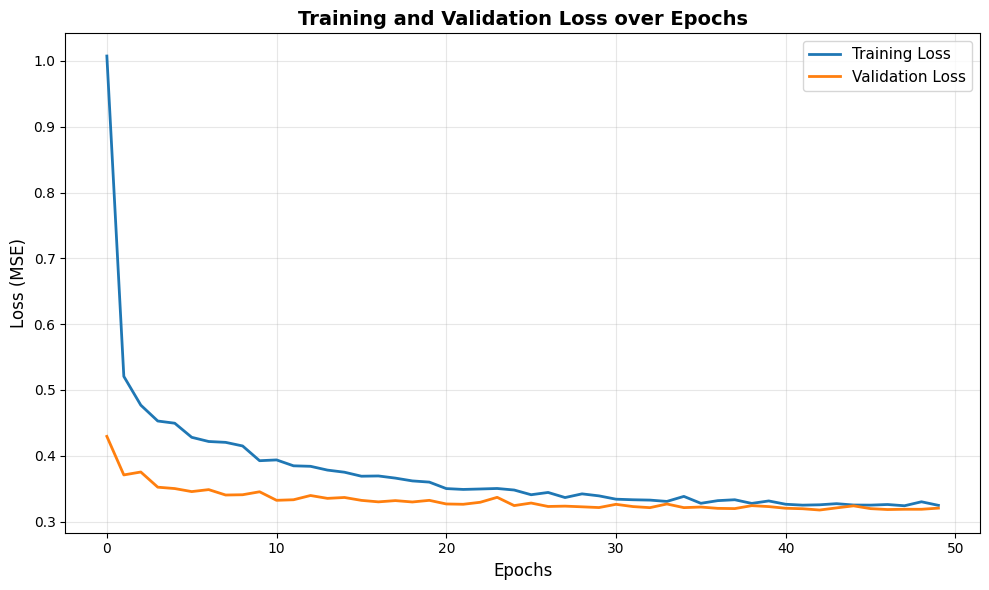

In [23]:
# Create a plot for training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(total_loss_train_plot, label='Training Loss', linewidth=2)
plt.plot(total_loss_validation_plot, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Testing

Now in this section, we will be testing our model. We will start the code with `torch.no_grad()` which means that we are telling PyTorch that we don't want to train the model, we will be using it only for testing. Then we will declare initial loss as zero and empty lists for predictions and actual values.

We will start by looping through the testing dataloader like we did before during training. Inside the loop, we get our data and we run our model on the data to get the predictions. We calculate the loss and add it to our overall loss. We also collect predictions and actual values to calculate additional regression metrics.

**Key differences from classification:**
- Instead of accuracy, we calculate regression metrics: MSE, RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and R² score
- R² score tells us the proportion of variance explained by our model (1.0 is perfect, 0.0 means the model is no better than predicting the mean)
- MAPE gives us the average percentage error, making it easy to interpret (e.g., 10% means predictions are off by 10% on average)
- We compare continuous predicted values directly with actual values, no rounding needed

In [24]:
# Set model to evaluation mode
model.eval()

# Disable gradient calculation for testing (no backpropagation needed)
with torch.no_grad():
    # Initialize testing metrics
    total_loss_test = 0
    all_predictions = []  # Store all predictions
    all_actuals = []  # Store all actual values
    
    # Loop through all batches in the testing dataset
    for data in testing_dataloader:
        # Unpack batch
        inputs, labels = data

        # Forward pass: get predictions
        prediction = model(inputs).squeeze(1)

        # Calculate loss for this batch
        batch_loss_test = criterion(prediction, labels)
        
        # Accumulate testing loss
        total_loss_test += batch_loss_test.item()
        
        # Store predictions and actual values for metrics calculation
        all_predictions.extend(prediction.cpu().numpy())
        all_actuals.extend(labels.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_loss_test / len(testing_dataloader)

# Convert lists to numpy arrays for sklearn metrics
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate regression metrics
mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(all_actuals, all_predictions)  # Mean Absolute Error
mape = np.mean(np.abs((all_actuals - all_predictions) / all_actuals)) * 100  # Mean Absolute Percentage Error
r2 = r2_score(all_actuals, all_predictions)  # R² score

# Print final testing metrics
print("="*70)
print("TESTING RESULTS")
print("="*70)
print(f"Mean Squared Error (MSE):        {mse:12.4f}")
print(f"Root Mean Squared Error (RMSE):  {rmse:12.4f}")
print(f"Mean Absolute Error (MAE):       {mae:12.4f}")
print(f"Mean Absolute Percentage Error:  {mape:12.4f}%")
print(f"R² Score:                        {r2:12.4f}")
print("="*70)
print("\nInterpretation:")
print(f"- On average, predictions are off by ${mae:,.2f} (MAE)")
print(f"- On average, predictions are off by {mape:.2f}% (MAPE)")
print(f"- The model explains {r2*100:.2f}% of the variance in house prices (R²)")

TESTING RESULTS
Mean Squared Error (MSE):              0.3228
Root Mean Squared Error (RMSE):        0.5682
Mean Absolute Error (MAE):             0.4367
Mean Absolute Percentage Error:       28.2431%
R² Score:                              0.6178

Interpretation:
- On average, predictions are off by $0.44 (MAE)
- On average, predictions are off by 28.24% (MAPE)
- The model explains 61.78% of the variance in house prices (R²)


## Additional Testing Analysis

Let's create some visualizations to better understand our model's performance:

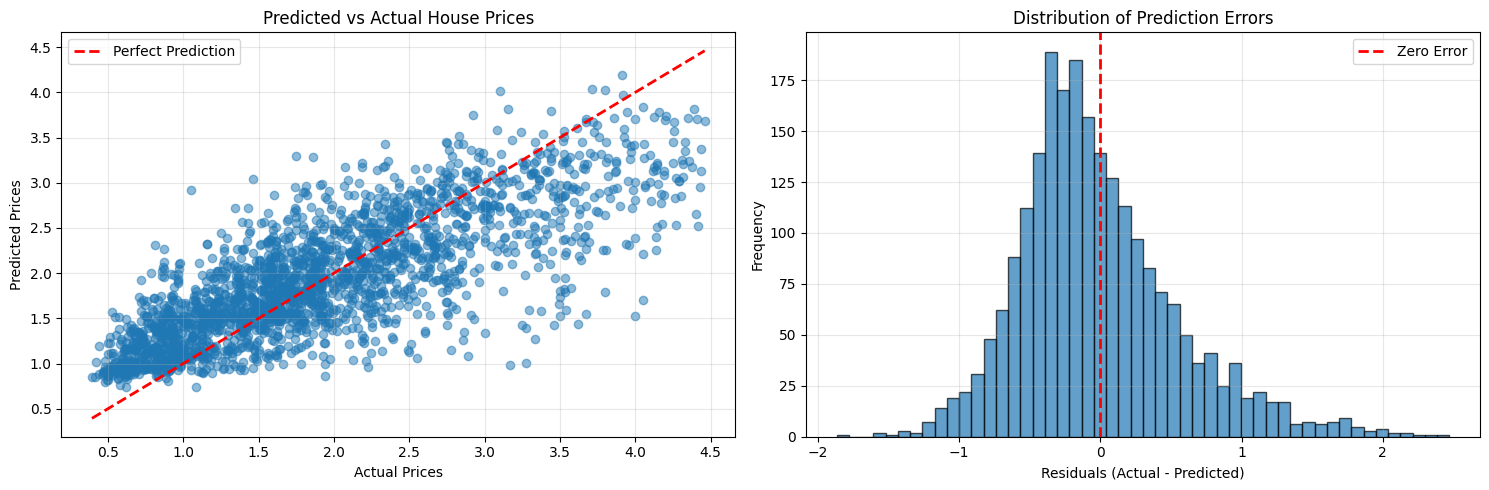


Residual Statistics:
Mean of residuals: -0.0190 (should be close to 0)
Std of residuals: 0.5679


In [25]:
# Create a figure with multiple subplots for analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Predicted vs Actual values
axes[0].scatter(all_actuals, all_predictions, alpha=0.5)
axes[0].plot([all_actuals.min(), all_actuals.max()], 
             [all_actuals.min(), all_actuals.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Prices')
axes[0].set_ylabel('Predicted Prices')
axes[0].set_title('Predicted vs Actual House Prices')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals (errors) distribution
residuals = all_actuals - all_predictions
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residuals (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Errors')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"Mean of residuals: {residuals.mean():.4f} (should be close to 0)")
print(f"Std of residuals: {residuals.std():.4f}")

In [44]:
# Save the model state dict (recommended approach)
torch.save(model.state_dict(), 'sklearn_house_price_regression_model.pth')

# Optionally save additional information for reproducibility
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_size': X_train.shape[1],
    'hidden_neurons_1': HIDDEN_NEURONS_1,
    'hidden_neurons_2': HIDDEN_NEURONS_2,
    'final_train_loss': total_loss_train_plot[-1],
    'final_val_loss': total_loss_validation_plot[-1],
    'test_mse': mse,
    'test_r2': r2
}, 'sklearn_house_price_regression_checkpoint.pth')

print("Model saved successfully!")
print("\nFiles created:")
print("  - house_price_regression_model.pth (model weights only)")
print("  - house_price_regression_checkpoint.pth (full checkpoint with metadata)")

print("\nTo load the model later:")
print("  model = RegressionModel(input_size=X.shape[1]).to(device)")
print("  model.load_state_dict(torch.load('house_price_regression_model.pth'))")
print("  model.eval()")

Model saved successfully!

Files created:
  - house_price_regression_model.pth (model weights only)
  - house_price_regression_checkpoint.pth (full checkpoint with metadata)

To load the model later:
  model = RegressionModel(input_size=X.shape[1]).to(device)
  model.load_state_dict(torch.load('house_price_regression_model.pth'))
  model.eval()


## Inference

Now let's see how we can use the model in inference mode. Inference means making predictions like you are in production.

**Important**: You need to preprocess your input data the same way you preprocessed your training data:
- Apply the same scaling/normalization
- Encode categorical variables the same way
- Use the same feature order

In [50]:
# Example: Load a saved model and make predictions
# This demonstrates how to use a previously saved model for inference

# Step 1: Load the saved model
# First, create a new model instance with the same architecture
loaded_model = RegressionModel(
    input_size=X_train.shape[1]
).to(device)

# Load the saved weights
loaded_model.load_state_dict(torch.load('sklearn_house_price_regression_model.pth'))
loaded_model.eval()  # Set to evaluation mode

print("Model loaded successfully from 'sklearn_house_price_regression_model.pth'")
print()

# Step 2: Prepare input data (same preprocessing as training)
# Let's use an example from the test set to demonstrate
sample_idx = np.random.randint(0, len(X_test))  # Random sample from test set

# Check if X_test is DataFrame or numpy array and handle accordingly
if hasattr(X_test, 'iloc'):
    sample_features = X_test.iloc[sample_idx].values  # DataFrame: use .iloc[]
else:
    sample_features = X_test[sample_idx]  # Numpy array: use direct indexing

# y_test is a numpy array, so use direct indexing
actual_price = y_test[sample_idx]

# Step 3: Convert to tensor and add batch dimension
model_input = torch.tensor(sample_features, dtype=torch.float32).unsqueeze(0).to(device)

# Step 4: Make prediction with the loaded model
with torch.no_grad():
    predicted_price = loaded_model(model_input).item()

print("="*70)
print("INFERENCE EXAMPLE (Using Loaded Model)")
print("="*70)
print(f"Actual Price:    ${actual_price:,.2f}")
print(f"Predicted Price: ${predicted_price:,.2f}")
print(f"Difference:      ${abs(actual_price - predicted_price):,.2f}")
print(f"Error Percentage: {abs(actual_price - predicted_price) / actual_price * 100:.2f}%")
print("="*70)

Model loaded successfully from 'sklearn_house_price_regression_model.pth'

INFERENCE EXAMPLE (Using Loaded Model)
Actual Price:    $0.75
Predicted Price: $83.16
Difference:      $82.41
Error Percentage: 10988.48%


In [ ]:
# Example: Make a prediction for a new house using the notebook run model
# You need to prepare your input with the same preprocessing as training data

# Let's use an example from the test set to demonstrate
sample_idx = np.random.randint(0, len(X_test))  # Random sample from test set

# Check if X_test is DataFrame or numpy array and handle accordingly
if hasattr(X_test, 'iloc'):
    sample_features = X_test.iloc[sample_idx].values  # DataFrame: use .iloc[]
else:
    sample_features = X_test[sample_idx]  # Numpy array: use direct indexing

# y_test is a numpy array, so use direct indexing
actual_price = y_test[sample_idx]

# Convert to tensor and add batch dimension
model_input = torch.tensor(sample_features, dtype=torch.float32).unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    predicted_price = model(model_input).item()

print("="*70)
print("INFERENCE EXAMPLE")
print("="*70)
print(f"Actual Price:    ${actual_price:,.2f}")
print(f"Predicted Price: ${predicted_price:,.2f}")
print(f"Difference:      ${abs(actual_price - predicted_price):,.2f}")
print(f"Error Percentage: {abs(actual_price - predicted_price) / actual_price * 100:.2f}%")
print("="*70)

INFERENCE EXAMPLE
Actual Price:    $3.80
Predicted Price: $144.24
Difference:      $140.44
Error Percentage: 3695.66%
